<a href="https://colab.research.google.com/github/iEpsilon-FPS/QU-MLinF/blob/master/5.1%20Exploring_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Module: Data Science in Finance, Orientation on the Credit risk case study
# Version 2.0
# Topic : Exploring Data sets to make sense in Python
# Example source: https://www.kaggle.com/wendykan/lending-club-loan-data
#####################################################################
# For support or questions, contact QuantUniversity at
# info@qusandbox.com
# Copyright 2020 QuantUniversity LLC.
#####################################################################

In [ ]:
!pip install pandas_profiling
!pip install pandas==0.25
# One time install. Restart runtime by going to Runtime->Restart Runtime after installing these packages

     |████████████████████████████████| 10.5MB 4.3MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.25.0 which is incompatible.
  Found existing installation: pandas 1.0.4
    Uninstalling pandas-1.0.4:
      Successfully uninstalled pandas-1.0.4


#  Exploring Data sets to make sense in Python

This notebook deals with understanding the lending data obtained from https://www.kaggle.com/wendykan/lending-club-loan-data

## Imports

In [ ]:
# for numerical analysis and data processing
import numpy as np
import pandas as pd
import itertools

# for Machine learning algorithms
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# for vizualizations
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Dataset

The data set is the lending data obtained from LendingClub from August 2011 to December 2011 for some borrowers. The feature descriptions for the data are also provided. Not all the features are required for making predictions, some features are redundant in the original data file. The provided data file is already cleaned and only relevant features are provided. There are two types of features, numerical and categorical.

Reading the input data from csv file.

In [ ]:
df = pd.read_csv("https://mlinfinancefiles.s3-us-west-2.amazonaws.com/SupervisedLearning/CreditRiskCase/LendingClubLoan.csv", low_memory=False)
df_description = pd.read_excel('https://mlinfinancefiles.s3-us-west-2.amazonaws.com/SupervisedLearning/CreditRiskCase/LCDataDictionary.xlsx').dropna()
df_description.head(10)

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
5,annual_inc_joint,The combined self-reported annual income provi...
6,application_type,Indicates whether the loan is an individual ap...
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/...


### Check shape of dataframe and columns types
Categorical features are represented as _object_ type. This dataset has 9999 samples with 17 features.

In [ ]:
print(df.shape)
df.head()

(9999, 17)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,loan_status_Binary
0,5000,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,11-Dec,credit_card,AZ,27.65,0,1,0
1,2500,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,11-Dec,car,GA,1.00,0,5,1
2,2400,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,11-Dec,small_business,IL,8.72,0,2,0
3,10000,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,11-Dec,other,CA,20.00,0,1,0
4,3000,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,11-Dec,other,OR,17.94,0,0,0


In [ ]:
del df['issue_d'] # removing issue date as it wont affect the prediction (redundant feature)

## Distribution of data types in features
This data set have equal number of catgorical and numerical features.

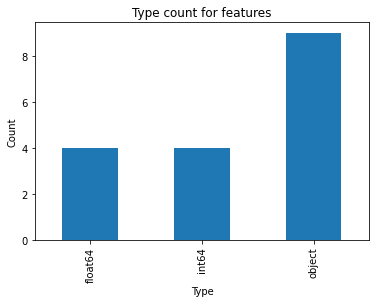

In [ ]:
plt.title('Type count for features')
plt.xlabel('Type')
plt.ylabel('Count')
df.dtypes.value_counts().sort_values().plot(kind='bar')
plt.show()

## Numerical data

### Correlation matrix for numerical data


We can calculate the corelation matrix for the given numerical features to see the relation or dependency of features among themselves. Each cell in the matrix describes the Pearson Correlation coefficient, a value between -1 and 1. A correlation coefficient indicates the extent to which dots in a scatterplot lie on a straight line. This implies that we can usually estimate correlations pretty accurately from nothing more than scatterplots. +1 is highly linearly related and -1 is highly negatively linearly related. A fractional number indicates deviation from a linear trend. 

['loan_amnt' 'int_rate' 'installment' 'annual_inc' 'dti' 'delinq_2yrs'
 'inq_last_6mths' 'loan_status_Binary']


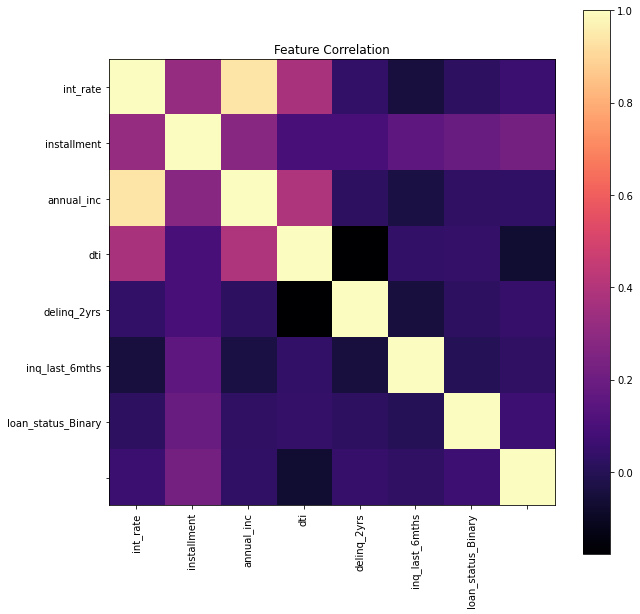

In [ ]:
def correlation_matrix(df):
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('magma')
    corr = df.corr()
    cax = ax1.imshow(corr, interpolation="nearest", cmap=cmap)
    plt.title('Feature Correlation')
    labels = df.columns.values
    print(labels)
    ax1.set_xticklabels(corr.columns,fontsize=10, rotation=90)
    ax1.set_yticklabels(corr.columns,fontsize=10)
    fig.colorbar(cax)
    plt.show()

correlation_matrix(df.select_dtypes(include=['float64','int64']))

For the given dataset, it is evident fom the correlation matrix that the _installment_ is somewhat related to all other numerical features. Also, _interst rate_, _annual income_ and _dti_ have some sort of linear relationship.

## Categorical Features

### Preparing categorical features

Categorical data is best processed by algorithms when converted to numerical format.An intuitive way would be to map each category to an integers. Ex. \[A, B, C\] can be mapped to \[0, 1, 2\]. Another way is one-hot encoding which we will look into while building the models.

Get a list of all numerical and categorical features

In [ ]:
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [ ]:
print(numeric_columns)
print(categorical_columns)

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'loan_status_Binary'],
      dtype='object')
Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'purpose', 'addr_state'],
      dtype='object')


Change type from object to category

In [ ]:
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [ ]:
p_categories = df['purpose'].cat.categories.tolist()
s_categories = df['addr_state'].cat.categories.tolist()
print(dict( enumerate(df['purpose'].cat.categories) ))

df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes)

{0: 'car', 1: 'credit_card', 2: 'debt_consolidation', 3: 'home_improvement', 4: 'house', 5: 'major_purchase', 6: 'medical', 7: 'moving', 8: 'other', 9: 'renewable_energy', 10: 'small_business', 11: 'vacation', 12: 'wedding'}


## Summary of features

### Summary of categorical features

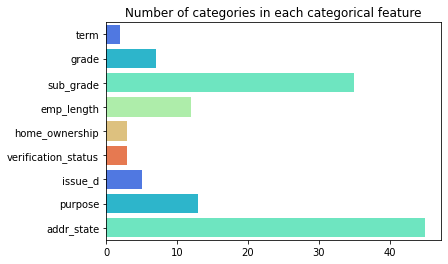

In [ ]:
# Barplot
sns.barplot(y = categorical_columns, x = df[categorical_columns].apply(pd.Series.nunique, axis = 0).tolist(), palette=sns.color_palette("rainbow"))
plt.title('Number of categories in each categorical feature')
plt.show()

### Summary of numerical features

In [ ]:
df.select_dtypes(include=['float64','int64']).describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,loan_status_Binary
count,9999.000000,9999.000000,9999.000000,9.999000e+03,9999.000000,9999.000000,9999.000000,9999.000000
mean,12861.456146,12.428641,363.819195,7.027073e+04,13.989643,0.133513,0.849685,0.155616
std,8492.219046,4.239319,226.220788,4.832171e+04,6.612583,0.459694,1.040444,0.362509
min,1000.000000,5.420000,22.240000,6.000000e+03,0.000000,0.000000,0.000000,0.000000
25%,6000.000000,8.900000,193.580000,4.200000e+04,8.940000,0.000000,0.000000,0.000000
50%,11200.000000,12.420000,322.250000,6.000000e+04,14.020000,0.000000,1.000000,0.000000
75%,17500.000000,15.270000,480.330000,8.450000e+04,19.150000,0.000000,1.000000,0.000000
max,35000.000000,24.110000,1288.100000,1.782000e+06,29.920000,6.000000,8.000000,1.000000


### Summary of loan amounts

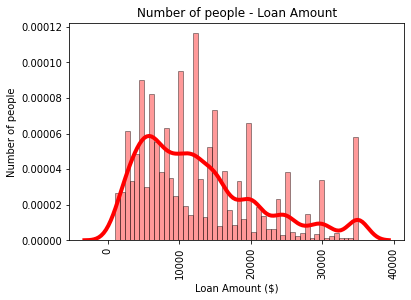

count     9999.000000
mean     12861.456146
std       8492.219046
min       1000.000000
25%       6000.000000
50%      11200.000000
75%      17500.000000
max      35000.000000
Name: loan_amnt, dtype: float64


In [ ]:
# Histogram and density chart
sns.distplot(df['loan_amnt'], hist=True, kde=True, 
             bins=50, color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xticks(rotation=90)
plt.title('Number of people - Loan Amount')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Number of people')
plt.show()

print(df['loan_amnt'].describe())

### Summary of Annual incomes

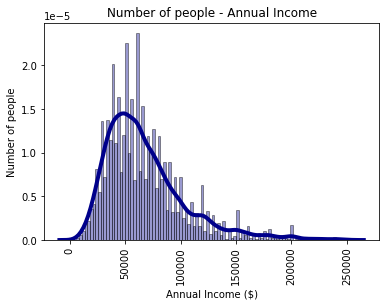

count    9.999000e+03
mean     7.027073e+04
std      4.832171e+04
min      6.000000e+03
25%      4.200000e+04
50%      6.000000e+04
75%      8.450000e+04
max      1.782000e+06
Name: annual_inc, dtype: float64


In [ ]:
# Histogram and density chart
sns.distplot(df[df['annual_inc'] <250000]['annual_inc'], hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xticks(rotation=90)
plt.title('Number of people - Annual Income')
plt.xlabel('Annual Income ($)')
plt.ylabel('Number of people')
plt.show()

print(df['annual_inc'].describe())

### Loan Purposes distribution
By looking at the distribution, it can be seen that debt consolidation is one of the major resons for loan. In the given dataset, the number of samples having debt consolidation as the purpose are significantly more than other  purposes.

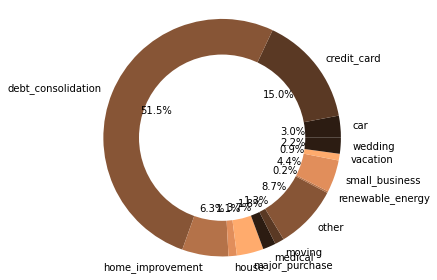

count    9999.000000
mean        3.303230
std         2.923144
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        12.000000
Name: purpose, dtype: float64


In [ ]:
# Circle chart
fig1, ax1 = plt.subplots()
ax1.pie(df['purpose'].value_counts().sort_index().tolist(),
        labels=p_categories,
        autopct='%1.1f%%',
        colors= sns.color_palette("copper"))

ax1.axis('equal')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
  
plt.tight_layout()
plt.show()


# Summary
print(df['purpose'].describe())

### State wise customer distribution
The states of Californial has the highest number of borrowers followed by New York and Florida.

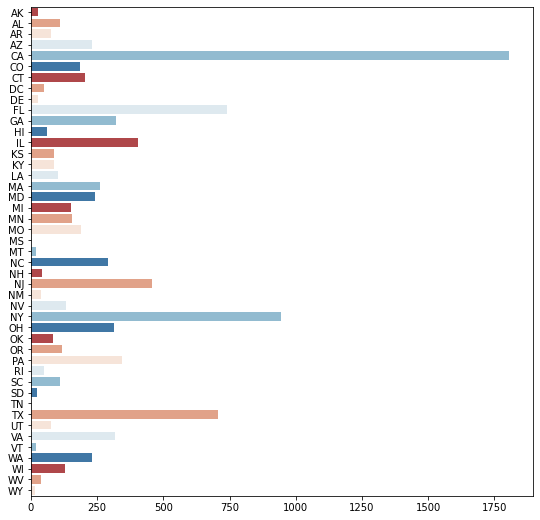

count    9999.000000
mean       18.993199
std        12.703174
min         0.000000
25%         6.000000
50%        17.000000
75%        29.000000
max        44.000000
Name: addr_state, dtype: float64


In [ ]:
# Bar chart
fig, ax = plt.subplots(figsize=(9,9))
sns.barplot(x=df['addr_state'].value_counts().sort_index().tolist(), y = s_categories, palette=sns.color_palette("RdBu"))
plt.show()

#Summary
print(df['addr_state'].describe())

## Dataset Overview

In [ ]:
import pandas_profiling as ppf

df = pd.read_csv("../data/LendingClubLoan.csv", low_memory=False)
profile = ppf.ProfileReport(df)
profile.to_file(outputfile="lending_data.html")

FileNotFoundError: ignored

In [ ]:
ppf.ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,17
Number of observations,9999
Total Missing (%),0.0%
Total size in memory,712.9 KiB
Average record size in memory,73.0 B
Numeric,12
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,3


# End